In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Make Input

In [3]:
def calculateWeight(tlx):
    tlx_weight = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Sum':[0]}
    tlx_weight = pd.DataFrame(tlx_weight)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col1 in range(1,len(tlx.columns)):
            for col2 in range(col1+1, len(tlx.columns)):
                if tlx[tlx.columns[col1]][i] > tlx[tlx.columns[col2]][i]:
                    score[col1-1]+=1
                elif tlx[tlx.columns[col1]][i] < tlx[tlx.columns[col2]][i]:
                    score[col2-1]+=1
                else :
                    score[col1-1]+=0.5
                    score[col2-1]+=0.5
                    
        score[6] = score[0]+score[1]+score[2]+score[3]+score[4]+score[5]
        tlx_weight.loc[i]=score
    #print(tlx_weight.loc[0])
    return tlx_weight

def calculate_tlxLevel(tlx, tlx_weight):
    result = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Score':[0]}
    result = pd.DataFrame(result)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col in range(len(tlx_weight.columns)-1):
            score[col] = int(tlx[tlx.columns[col+1]].loc[i] * tlx_weight[tlx_weight.columns[col]].loc[i] )
        score[6] =int((score[0]+score[1]+score[2]+score[3]+score[4]+score[5] )/ tlx_weight[tlx_weight.columns[6]].loc[i]/10 + 0.5)
        if score[6]>10: score[6]=10
        if score[6]<0: score[6]=0
        result.loc[i]=score
    return result['Score']

In [4]:
def cal_theta_alpha(df):
    col = ['POW.AF3.Theta', 'POW.AF3.Alpha', 'POW.F7.Theta', 'POW.F7.Alpha', 
           'POW.F3.Theta', 'POW.F3.Alpha', 'POW.FC5.Theta', 'POW.FC5.Alpha', 
           'POW.T7.Theta', 'POW.T7.Alpha', 'POW.P7.Theta', 'POW.P7.Alpha',
           'POW.O1.Theta', 'POW.O1.Alpha', 'POW.O2.Theta', 'POW.O2.Alpha', 
           'POW.P8.Theta', 'POW.P8.Alpha', 'POW.T8.Theta', 'POW.T8.Alpha',
           'POW.FC6.Theta', 'POW.FC6.Alpha',  'POW.F4.Theta', 'POW.F4.Alpha', 
           'POW.F8.Theta', 'POW.F8.Alpha','POW.AF4.Theta', 'POW.AF4.Alpha','MarkerValueInt']
    col_rename = ['AF3.Theta', 'AF3.Alpha', 'F7.Theta','F7.Alpha', 
                               'F3.Theta', 'F3.Alpha', 'FC5.Theta', 'FC5.Alpha', 
                               'T7.Theta', 'T7.Alpha', 'P7.Theta', 'P7.Alpha', 
                               'O1.Theta', 'O1.Alpha', 'O2.Theta', 'O2.Alpha',
                               'P8.Theta', 'P8.Alpha', 'T8.Theta','T8.Alpha',
                               'FC6.Theta', 'FC6.Alpha', 'F4.Theta', 'F4.Alpha', 
                               'F8.Theta', 'F8.Alpha', 'AF4.Theta', 'AF4.Alpha','vis_name']
    col2 = ['AF3', 'F7','F3', 'FC5', 'T7', 'P7', 'O1', 'O2',
            'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4','vis_name']
    data_extraction = df[col]
    data_extraction.columns = col_rename
    
    for i in range(0,len(col2)-1):
        data_extraction[col2[i]]=data_extraction[col_rename[2*i]]/data_extraction[col_rename[2*i+1]]
    result = data_extraction[col2]
    return result

def split_theta_alpha_data(df, label, end):
    data_extraction = cal_theta_alpha(df)
    rest = data_extraction[data_extraction.vis_name == 0].dropna(axis=0)
    survey = data_extraction[data_extraction.vis_name == 100].dropna(axis=0)
    
    vis = data_extraction[data_extraction.vis_name == 1].reset_index(drop=True).dropna(axis=0)
    vis['label'] = label[0]
    vis.drop(['vis_name'], axis=1, inplace=True)
    
    for i in range(2,end):
        df = data_extraction[data_extraction.vis_name == i].reset_index(drop=True)
        df['label'] = label[i-1]
        df.drop(['vis_name'], axis=1, inplace=True)
        df = df.dropna(axis=0)
        vis = pd.concat([vis,df], ignore_index=True, axis=0)
    return rest, survey, vis

In [5]:
src = 'C:/EEG data/User/'
files = os.listdir(src)
tlx=[]
for f in files:
    tlx.append(pd.read_csv(src+f))
src = 'C:/EEG data/prepross/'
datas = os.listdir(src)
workloadLevel = []
for t in tlx:
    workloadLevel.append(calculate_tlxLevel(t, calculateWeight(t)))
eegData=[]
for d in datas:
    eegData.append(pd.read_csv(src+d))

In [6]:
cnt = 0
for eeg, label in zip (eegData, workloadLevel):
    if cnt == 0 :
        rest, survey, vis = split_theta_alpha_data(eeg, label,21)
        cnt+=1
        continue
    elif cnt == 6:
        r, s, v = split_theta_alpha_data(eeg, label,21)
    else:
        r, s, v = split_theta_alpha_data(eeg, label, 22)
    
    rest = pd.concat([rest,r], ignore_index=True, axis=0)
    survey = pd.concat([survey,s], ignore_index=True, axis=0)
    vis = pd.concat([vis,v], ignore_index=True, axis=0)
    cnt+=1

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

label=vis['label']
label = to_categorical(label,11)
data=vis.drop(['label'],axis=1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
data = pd.DataFrame(scaled, columns = data.columns, index=data.index)
data
print(data.shape, label.shape)

(108212, 14) (108212, 11)


In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data,label, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = label)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y_test)

print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(64927, 14) (21642, 14) (21643, 14) (64927, 11) (21642, 11) (21643, 11)


# Model Tuning

In [11]:
import matplotlib.pyplot as plt

def drawResult(history):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()

In [12]:
from sklearn.metrics import f1_score

def runModel(name, model, crossentropy, x_train, y_train, x_valid, y_valid):
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model.compile(optimizer='adam', loss= crossentropy, metrics='accuracy')

    history = model.fit(x_train, y_train, 
                        epochs = 300, 
                        validation_data = (x_valid, y_valid), 
                        callbacks=[early_stop], verbose=1)
    drawResult(history)
    
    return model
    
def eval_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

In [13]:
import autokeras as ak
from tensorflow.keras.utils import plot_model
from datetime import datetime

from autokeras.keras_layers import ExpandLastDim, MultiCategoryEncoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation, RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.applications import EfficientNetB7
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# DNN

Epoch 1/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.8025 - accuracy: 0.2807 - val_loss: 1.7563 - val_accuracy: 0.3105
Epoch 2/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.7364 - accuracy: 0.3023 - val_loss: 1.7116 - val_accuracy: 0.3088
Epoch 3/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.7071 - accuracy: 0.3072 - val_loss: 1.7092 - val_accuracy: 0.3063
Epoch 4/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.6930 - accuracy: 0.3102 - val_loss: 1.6910 - val_accuracy: 0.3030
Epoch 5/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.6793 - accuracy: 0.3149 - val_loss: 1.6782 - val_accuracy: 0.3134
Epoch 6/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.6697 - accuracy: 0.3203 - val_loss: 1.6678 - val_accuracy: 0.3244
Epoch 7/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.6596 - accuracy: 0.3270 - val_loss: 1.6577 - val_ac

2029/2029 [==============================] - 6s 3ms/step - loss: 1.4688 - accuracy: 0.4085 - val_loss: 1.5160 - val_accuracy: 0.3894
Epoch 58/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.4652 - accuracy: 0.4098 - val_loss: 1.5162 - val_accuracy: 0.3933
Epoch 59/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.4621 - accuracy: 0.4110 - val_loss: 1.5115 - val_accuracy: 0.3977
Epoch 60/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.4630 - accuracy: 0.4113 - val_loss: 1.5019 - val_accuracy: 0.3965
Epoch 61/300
2029/2029 [==============================] - 5s 3ms/step - loss: 1.4559 - accuracy: 0.4137 - val_loss: 1.5125 - val_accuracy: 0.4001
Epoch 62/300
2029/2029 [==============================] - 5s 3ms/step - loss: 1.4531 - accuracy: 0.4150 - val_loss: 1.5021 - val_accuracy: 0.4000
Epoch 63/300
2029/2029 [==============================] - 5s 3ms/step - loss: 1.4492 - accuracy: 0.4177 - val_loss: 1.4999 - val_accuracy

2029/2029 [==============================] - 6s 3ms/step - loss: 1.3014 - accuracy: 0.4804 - val_loss: 1.4372 - val_accuracy: 0.4354
Epoch 114/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.3020 - accuracy: 0.4845 - val_loss: 1.4463 - val_accuracy: 0.4302
Epoch 115/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.2975 - accuracy: 0.4821 - val_loss: 1.4440 - val_accuracy: 0.4382
Epoch 116/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.2956 - accuracy: 0.4841 - val_loss: 1.4396 - val_accuracy: 0.4322
Epoch 117/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.2936 - accuracy: 0.4868 - val_loss: 1.4480 - val_accuracy: 0.4318
Epoch 118/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.2962 - accuracy: 0.4871 - val_loss: 1.4381 - val_accuracy: 0.4341
Epoch 119/300
2029/2029 [==============================] - 6s 3ms/step - loss: 1.2861 - accuracy: 0.4907 - val_loss: 1.4233 - val_ac

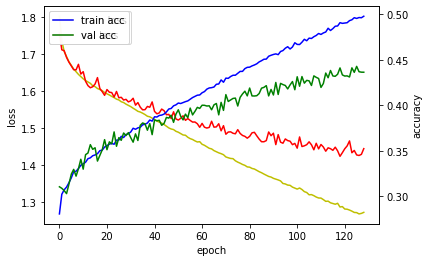

0.3831633807657977

In [15]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(14)))
    #MultiCategoryEncoding
    #Normailzation
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    #model.summary()
    return model

crossentropy = 'categorical_crossentropy'

f1_score_DNN = eval_model(runModel('DNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)
f1_score_DNN

In [16]:
f1_score_DNN

0.3831633807657977

# 1D CNN

In [31]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(14)))
    model.add(ExpandLastDim())
    model.add(Conv1D(1024, 3, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(512, 3, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_CNN_1 = eval_model(runModel('CNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

Epoch 1/300
2029/2029 [==============================] - 93s 46ms/step - loss: 1.8584 - accuracy: 0.2550 - val_loss: 1.8101 - val_accuracy: 0.2753
Epoch 2/300
2029/2029 [==============================] - 94s 46ms/step - loss: 1.7996 - accuracy: 0.2788 - val_loss: 1.7697 - val_accuracy: 0.2998
Epoch 3/300
2029/2029 [==============================] - 94s 46ms/step - loss: 1.7691 - accuracy: 0.2895 - val_loss: 1.7440 - val_accuracy: 0.3032
Epoch 4/300
2029/2029 [==============================] - 94s 46ms/step - loss: 1.7438 - accuracy: 0.2990 - val_loss: 1.7186 - val_accuracy: 0.3063
Epoch 5/300
2029/2029 [==============================] - 84s 42ms/step - loss: 1.7291 - accuracy: 0.2996 - val_loss: 1.7112 - val_accuracy: 0.3043
Epoch 6/300
2029/2029 [==============================] - 83s 41ms/step - loss: 1.7181 - accuracy: 0.3032 - val_loss: 1.6990 - val_accuracy: 0.3067
Epoch 7/300
2029/2029 [==============================] - 83s 41ms/step - loss: 1.7091 - accuracy: 0.3071 - val_loss: 1

KeyboardInterrupt: 

In [ ]:
f1_score_CNN_1

In [ ]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(14)))
    model.add(ExpandLastDim())
    model.add(Conv1D(1024, 3, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(512, 3, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_CNN_2 = eval_model(runModel('CNN',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

In [ ]:
f1_score_CNN_2

# LSTM

In [ ]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(14)))
    model.add(ExpandLastDim())
    model.add(LSTM(512))
    model.add(ExpandLastDim())
    model.add(LSTM(64))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_LSTM = eval_model(runModel('LSTM',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

In [ ]:
f1_score_LSTM

# 1D CNN + LSTM

In [ ]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(14)))
    model.add(ExpandLastDim())
    model.add(Conv1D(1024, 3, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(512, 3, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(ExpandLastDim())
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_CNN_LSTM = eval_model(runModel('CNN_LSTM',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

In [ ]:
f1_score_CNN_LSTM

# windowing LSTM

In [ ]:
def windowing_dataset(data, label, window_size):
    data_list = []
    label_list = []
    
    for i in range(0,len(data)//window_size):
        data_list.append(np.array(data.iloc[i*window_size:(i+1)*window_size]))
        label_list.append(np.array(label.iloc[i*window_size]))
    return np.array(data_list), np.array(label_list)

data_l, label_l = windowing_dataset(data,pd.DataFrame(label),14)
x_train, x_test, y_train, y_test = train_test_split(data_l,label_l, 
                                                    train_size=0.6, 
                                                    random_state=True,
                                                    stratify = label_l)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, 
                                                    train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y_test)

print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)

In [ ]:
def Model():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(LSTM(512))
    model.add(ExpandLastDim())
    model.add(LSTM(64))
    model.add(Dense(11, activation='sigmoid'))
    return model

crossentropy = 'categorical_crossentropy'

f1_score_wLSTM = eval_model(runModel('wLSTM',Model(),crossentropy, x_train, y_train, x_valid, y_valid), x_test, y_test)

In [ ]:
f1_score_wLSTM